### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2022 ###

# Road Trip Optimizer #
---
#### Alex Gilmore (asgilmore@wisc.edu), Nandan Venkatesan (nvenkatesan2@wisc.edu), and Brendan Zimmer (btzimmer@wisc.edu)

### Table of Contents

1. [Introduction](#1.-Introduction)
    1. [Data Collection](#Data-Collection)
2. [Mathematical Model](#2.-Mathematical-Model)
    1. [Traveling Salesman Variant](#a.-Traveling-Salesman-Variant)
    2. [Adaptive Subtour Elimination Model](#b.-Adapative-Subtour-Elimination-Model)
    3. [Miller-Tucker-Zemlin Model](#c.-Miller-Tucker-Zemlin-Model)
4. [Solution](#3.-Solution)
    1. [Data and Parameter Definition](#a.-Data-and-Parameter-Definition)
    2. [Modeling](#b.-Modeling)
        1. [Adaptive Subtour Elimination Method](#Adapative-Subtour-Elimination-Method)
        2. [Miller-Tucker-Zemlin Method](#Miller-Tucker-Zemlin-Method)
5. [Results and Discussion](#4.-Results-and-Discussion)
    1. [TSP Variant Results](#a.-TSP-Variant-Results)
    2. [ASE and MTZ Variant Results](#b-ASE-and-MTZ-Variant-Results)
    3. [Discussion and Limitations](#c.-Discussion-and-Limitations)
6. [Conclusion](#5.-Conclusion)
    1. [Future Direction](#Future-Direction)
7. [Sources](#5.-Sources)

## 1. Introduction ##
---
There are currently forty-eight national parks in the contiguous United States and many people from around the world dedicate a significant amount of their time to visit only a handful of them. Many of these parks can be difficult to reach and require different time commitments to fully appreciate. Additionally the underlying costs attributed to visiting each park can be a deciding factor for potential visitors.

In order to alleviate the stress of planning a summer road trip, we’ve decided to create an optimization model that will determine the best road trip route throughout the contiguous United States. To do this we will implement two types of models - a Traveling Salesman Problem, and an MCNF adaptation of the Traveling Salesman Problem, wherein we can visit any subset of nodes in question. The first TSP serves as a “global” solution, i.e., one that is viable if time and money are no factor; however, both models do aim to reduce the total cost of the trip. In our models, total cost is defined as a combination of the park entrance fee, estimated lodging costs, and gas prices. Our models use a starting location, which will be UW-Madison. This model, however, can be adapted for any start location - the only difference being distance and time data from the start location to every national park.

### Data Collection
---
All data gathered in this project is derived from the real-world. We obtained travel distances and times for every pair of parks (including the starting location) using a [custom script and the Google Maps API](https://github.com/nandanv2702/isye-524-project). This ensures that our model provides a robust, real-world solution. Updating this data regularly would further maintain the robustness of the model. 

Similarly, our park cost information was gathered from the National Parks Service site amongst other sources, and our gas cost information was obtained from the AAA. While there are certainly more costs to consider, we believe that we have successfully included those that would most significantly impact our solution to the optimal road trip.

## 2. Mathematical Model ##
---
Before we consider our mathematical models, let us define all parameters relevant to this problem

let p be a list of national parks and our source and sink location (UW-Madison)

let $x_{ij}$ be a matrix representing if an arc is chosen $\forall i \in p, \forall j \in p$

let $u_i$ be a vector representing the order of chosen nodes $\forall i \in p$

let $e_i$ be a vector of entrance fees $\forall i \in p$

let $l_i$ be a vector of est. lodging fees $\forall i \in p$

let $s_i$ be a vector of length of stays $\forall i \in p$

let $c_i$ be a vector of the total lodging and entrance fee cost $\forall i \in p$

let $g_{ij}$ be a matrix of gas prices $\forall i \in p, \forall j \in p$

let $D_{ij}$ be a matrix of  arc distances (miles) $\forall i \in p, \forall j \in p$

let $T_{ij}$ be a matrix of arc times (days) $\forall i \in p, \forall j \in p$

let M be the maximum days allowed to travel

let m be the minimum days allowed to travel

let n be the total number of locations that can be visited

let v be a variable for standard form adjustment

This problem can be modeled in multiple ways, but we will use a combination of 2 methods as our optimal solution. Before that, however, let us explore the "ideal" solution to this problem.

Note that the objective for all models listed are _the same_: 

Minimizing the total cost of visiting parks and the gas cost of traveling between all parks

### a. Traveling Salesman Variant
---
First, we will re-word this problem as follows: assuming no time or cost constraints for a given traveller, what is the most optimal route for said traveller to visit all parks in the contiguous United States? By modeling this problem as a Traveling Salesman Problem, we can find an optimal solution as follows

\begin{align*}
\underset{x}{\max} \ & - \underset{(ij) \in p}\Sigma\ c_{i} x_{ij} - \underset{(ij) \in p}\Sigma\ g_{ij} x_{ij}  & \\
\text{s.t.} \ & \underset{j \in p} \Sigma\ x_{ij} \le 1, \forall i \in p & \\
& \underset{i \in p} \Sigma\ x_{ij} \le 1, \forall j \in p & \\
& - \underset{j \in p} \Sigma\ x_{ij} \le - 1, \forall i \in p & \\
& - \underset{i \in p} \Sigma\ x_{ij} \le - 1, \forall j \in p & \\
& x_{ii} \le 0 & \\
& - x_{ii} \le 0 & \\
& x_{ij} \in \{0, 1\} \ \forall i \in p, \forall j \in p& \\
& & \\
\end{align*}

1, 2, 3, 4. This set requires that each node has one entering and one leaving edge.

5, 6. This set requires that there are no self-loops.

#### Arguments for a More Holistic Model

Although this model addresses the problem of finding the most cost-efficient way to visit all national parks in the United States, most individuals would consider a more practical solution - one that takes into consideration the following factors:
- Time constraints, e.g., a traveller would want a trip that takes between 4-7 days
- Cost constraints, e.g., one may not want to spend more than \$1000 on fuel, accommodation, and fees combined
- Visit only a subset of the parks in $p$, excluding the starting location

Note that the last constraint is implicitly defined in upcoming models. This is because the time and cost constraints would lead to only a subset of parks in `p` being visited, else, the problem would be infeasible.

Thus, we will consider two models (listed below) that utilize a Min-Cost Network Flow (MCNF) framework to solve our primary problem. The source and sink will be identical since we are interested in only round trips and we will be implementing a minimum trip length to prevent the model from cutting the trip short to reduce cost.

This problem, however, doesn't adhere to the "traditional" MCNF problem because all parks in $p$ have arcs to all other parks in $p$, i.e., flow in all directions is possible. Due to this behavior, our model modifies this MCNF framework to eliminate subtours using two methods, as described below.

### b. Adapative Subtour Elimination Model
---
This model utilizes iteration and eliminates any present subtours for the following run until a unified path is achieved. 

\begin{align*}
\underset{x}{\max} \ & - \underset{(ij) \in p}\Sigma\ c_{i} x_{ij} - \underset{(ij) \in p}\Sigma\ g_{ij} x_{ij}  & \\
\text{s.t.} \ & \underset{(ij) \in p}\Sigma\ s_{i} x_{ij} + \underset{(ij) \in p}\Sigma\ T_{ij} x_{ij} \le M &\\
& - \underset{(ij) \in p}\Sigma\ s_{i} x_{ij} - \underset{(ij) \in p}\Sigma\ T_{ij} x_{ij} \le - m &\\
& \underset{i \in p} \Sigma\ x_{i, origin} \le 1 & \\
& - \underset{i \in p} \Sigma\ x_{i, origin} \le -1 & \\
& \underset{j \in p} \Sigma\ x_{origin, j} \le 1 & \\
& - \underset{j \in p} \Sigma\ x_{origin, j} \le -1 & \\
& \underset{j \in p} \Sigma\ x_{ij} - \underset{i \in p} \Sigma\ x_{ij} \le 0 & \\
& - \underset{j \in p} \Sigma\ x_{ij} + \underset{i \in p} \Sigma\ x_{ij} \le 0 & \\
& x_{ij} \in \{0, 1\} \ \forall i \in p, \forall j \in p& \\
& & \\
\end{align*}

#### Variables


- $x_{ij}$ = $\left\{ \begin{array}{ll}
        1 \ \mbox{if arc $x_{ij}$ is in road trip path} \\
        0 \ \mbox{otherwise} & 
    \end{array} \right\}$
    


#### Constraints

1. The total time traveled must be less than the maximum travel time.


2. The total time traveled must be more than the minimum desired travel time. This prevents the model from decreasing the trip length in an effort to reduce the trip cost. 


3, 4, 5, 6. This requires the origin to be included in the sequence loop


7, 8. This pair requires that if a node has an active entering arc, it must have an active leaving arc.

9. $x_{ij}$ is either 0 or 1.


This model will hereafter be referred to as the __ASE__ model

### c. Miller-Tucker-Zemlin Model
---
This model utilizes logical constraints to ensure a unified path between the subset of selected nodes. 

\begin{align*}
\underset{x}{\max} \ & - \underset{(ij) \in p}\Sigma\ c_{i} x_{ij} - \underset{(ij) \in p}\Sigma\ g_{ij} x_{ij}  & \\
\text{s.t.} \ & \underset{(ij) \in p}\Sigma\ s_{i} x_{ij} + \underset{(ij) \in p}\Sigma\ T_{ij} x_{ij} \le M &\\
& - \underset{(ij) \in p}\Sigma\ s_{i} x_{ij} - \underset{(ij) \in p}\Sigma\ T_{ij} x_{ij} \le - m &\\
& \underset{i \in p} \Sigma\ x_{i, origin} \le 1 & \\
& - \underset{i \in p} \Sigma\ x_{i, origin} \le -1 & \\
& \underset{j \in p} \Sigma\ x_{origin, j} \le 1 & \\
& - \underset{j \in p} \Sigma\ x_{origin, j} \le -1 & \\
& \underset{j \in p} \Sigma\ x_{kj} \le 1, \forall k \in p & \\
& \underset{i \in p} \Sigma\ x_{ik} \le 1, \forall k \in p & \\
& u_i - u_j + n * x_{ij} \le n - 1, \forall i \in p, j \in p[1:length(p) - 1] &\\
& - \underset{k \in p} \Sigma\ x_{jk} + x_{ij} \le 0 , \forall i \in p, j \in p & \\
& x_{ij} \in \{0, 1\} \ \forall i \in p, \forall j \in p& \\
& 0 \le v & \\
& v \le n - 1 & \\
& v \le u_i - 1, \forall i \in p & \\
& - v \le - u_i + 1, \forall i \in p & \\
\end{align*}

_Note_: the `park_data.csv` file contains the source node and arcs from the source node as the last row; thus, the MTZ constraint is modeled for `p[1:length(p) - 1]` rather than `p[2:end]` as suggested in the lecture slides.

#### Variables

- $x_{ij}$ = $\left\{ \begin{array}{ll}
        1 \ \mbox{if arc $x_{ij}$ is in road trip path} \\
        0 \ \mbox{otherwise} & 
    \end{array} \right\}$
    
    
- $u_i$ = indicates the order of active nodes in the sequence

#### Constraints

1. The total time traveled must be less than the maximum travel time.


2. The total time traveled must be more than the minimum desired travel time. This prevents the model from decreasing the trip length in an effort to reduce the trip cost. 


3, 4, 5, 6. This requires the origin to be included in the sequence loop


7, 8. This pair requires that each node has at most one entering and at most one leaving edge


9. This is the Miller-Tucker-Zemlin logical constraint. It ensures that u will increase along successive nodes in the sequence.


10. This is a logical constraint that ensures if a node has an active entering arc, then it must have an active leaving arc.


11. $x_{ij}$ is either 0 or 1.

12, 13, 14, 15. $u_i$ has a lower bound of 1 and an upper bound of n

This model will hereafter be referred to as the __MTZ__ model

## 3. Solution ##
---
First, we will define the data required to run our models; next, we will derive a solution for the general TSP model, then the more practical ASE model, after which we will compare our results for accuracy using the MTZ model

### a. Data and Parameter Definition
---
In this section, we'll import and transform data to fit our needs. This includes data for:
- Distance taken to travel from $i$ to $j$, where $i$ and $j$ are parks in $p$
- Time taken to travel from $i$ to $j$, where $i$ and $j$ are parks in $p$
- Entrance fee for parks in $p$
- Lodging for parks in $p$
- Estimated length of stay for parks in $p$
- Gas price in the state where park $p$ is located

In [1]:
using Clp, Gurobi, JuMP, NamedArrays, CSV, DataFrames

In [2]:
df = DataFrame(CSV.File("park_data.csv"))

push!(df, ("source", "", 0, 0, 0, 3.5))

pTemp = df[!, "park name"]
p = Array{Symbol}(undef, length(pTemp))

# format parks list to symbols
for i in [1:1:length(pTemp);]
    pTemp[i] = replace(pTemp[i], " " => "_", "–" => "_", "." => "")
    p[i] = Symbol(pTemp[i])
end 

e = NamedArray(df[!, "entrance fee"], (p))

l = NamedArray(df[!, "lodging"], (p))

s = NamedArray(df[!, "est. length of stay"], (p))

parkGas = NamedArray(df[!, "gas price"], (p)) 

;

We consider cost $c$ as the sum of the lodging and entrance fee multiplied by the estimated length of stay. This combined variable is what is used to determine 

$c = s * (l + e)$

In [3]:
c = s .* (l + e)
;

In [4]:
dist = DataFrame(CSV.File("arc_data_dist_all.csv"))

time = DataFrame(CSV.File("arc_data_time_all.csv"))

size(time[1:49, 2:50])
size(p)
;

In [5]:
D = Float64.(NamedArray(Matrix(dist[1:49,2:50]), (p, p), ("entering", "leaving"))) # distances by arc
T = NamedArray(Matrix(time[1:49,2:50]), (p, p), ("entering", "leaving")) # times by arc
;

In [6]:
T = T ./ 86400 # convert time from seconds to days
;

For arc `(i,j)`, we consider the total gas cost $g$ in travelling from $i$ to $j$.

This is the average between the gas costs at each park (considered state-wise) $\frac{parkGas_i + parkGas_j}{2}$, multiplied by the gallons of gas used to travel distance $D_{ij}$ from `i` to `j`. In doing so, we estimate an average $milesPerGallon$ value one may expect from an average sedan in the United States.

The resultant formula for total gas cost from location $i$ to $j$ ($g_{ij}$) is shown below

$ g_{ij} =  \frac{parkGas_i + parkGas_j}{2} * \frac{1}{milesPerGallon} * D_{ij} $

In [7]:
# calculate the gas cost matrix

milesPerGallon = 20.0

g = copy(D)

for i in p
    for j in p
        g[i, j] = (parkGas[i] + parkGas[j]) / (2milesPerGallon) * g[i, j]
    end
end

println("Sample values for matrices D, g, and T (arc distance, arc time, arc gas cost, respectively) are shown below\n")
println("Acadia to Yosemite distance: ", D[:Acadia, :Yosemite], " miles")
println("Acadia to Yosemite estimated gas cost: \$", g[:Acadia, :Yosemite])
println("Acadia to Yosemite time : ", T[:Acadia, :Yosemite], " days")

Sample values for matrices D, g, and T (arc distance, arc time, arc gas cost, respectively) are shown below

Acadia to Yosemite distance: 3100.0 miles
Acadia to Yosemite estimated gas cost: $795.15
Acadia to Yosemite time : 1.9795138888888888 days


In [8]:
# Here are some custom parameters that can be modified as required
# Our solution is based on selecting values we deemed adequate, however,
# any values (provided they're feasible) should work
# set travel length boundaries
maxTravel = 14
minTravel = 7

# set n (total number of parks)
n = length(p)
;

### b. Modeling
---
#### Traveling Salesman Method
As mentioned earlier, this model addresses the overarching problem of finding the most cost-efficient way to visit all national parks in the United States. This model ensures all 48 parks in consideration are visited .ost individuals would consider a more practical solution 

In [9]:
# Defining TSP Model
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

@variable(m, x[p, p], Bin)
@variable(m, 1 <= u[p] <= n)

@expression(m, total_cost, sum(c[i] * x[i, j] for i in p for j in p) 
    + sum(g[i, j] * x[i, j] for i in p for j in p))

@objective(m, Min, total_cost)

# no self loops constraint
@constraint(m, x_constr[i in p], x[i, i] == 0)

# start at source, end at sink constraints
@constraint(m, start_constr, sum(x[:source, j] for j in p) == 1)
@constraint(m, end_constr, sum(x[i, :source] for i in p) == 1)

# MTZ logical constraint
@constraint(m, MTZ[i in p, j in p[1:length(p)-1]], u[i] - u[j] + n*x[i, j] <= n - 1)

# one out edge, one in edge constraints - the '==' ensures all parks are visited
@constraint(m, x_row_constr[k in p], sum(x[k, j] for j in p) == 1)
@constraint(m, x_col_constr[k in p], sum(x[i, k] for i in p) == 1)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [24]:
# Optimize and Calculate Summary Statistics for Optimal Solution
optimize!(m)

xTSP = value.(x)
tripMileageTSP = 0
tripDaysTSP = 0
driveTimeTSP = 0
parkTimeTSP = 0

objectiveTSP = objective_value(m)

for i in p
    for j in p
        if value(xTSP[i,j]) > 0
            # summary
            tripMileageTSP += D[i,j]
            tripDaysTSP += T[i,j]
            tripDaysTSP += s[i]
            
            # breakdown
            driveTimeTSP += value(xTSP[i,j])*T[i, j]
            parkTimeTSP += value(xTSP[i,j])*s[i]
        end
    end
end

#### Adapative Subtour Elimination Method
This helps eliminate subtours by adapting part of the TSP model but with only the set of nodes selected by the first optimal solution (that may include subtours). This limits subtour constraints by not forcing the model to visit all points.

First, we'll define helper functions that aid in eliminating subtours.

In [11]:
# Code adapted rom https://nbviewer.org/github/asmith28/cs524-su22/blob/main/TravelingSalesmanProblem.ipynb

# Returns the cycle containing the park START
function getSubtour(x,start)
    subtour = [start]
    while true
        j = subtour[end]
        for k in p
            if x[k,j] == 1
                push!(subtour,k)
                break
            end
        end
        if subtour[end] == start
            break
        end
    end
    return subtour
end

# Returns a list of all cycles
# given a list of specific parks (subset of `p`)
# for the ASE model
function getAllSubtours(x, specific_parks)
    nodesRemaining = specific_parks
    subtours = []
    while length(nodesRemaining) > 0
        subtour = getSubtour(x, nodesRemaining[1])
        push!(subtours, subtour)
        nodesRemaining = setdiff(nodesRemaining, subtour)
    end
    return subtours
end
;

Define the ASE Model with all data, variables and constraints

In [12]:
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

@variable(m, x[p, p], Bin) # flow from one park to another

# one in, one out
@constraint(m, c1[i in p], sum(x[i,:]) - sum(x[:,i]) == 0)

# enforce starting points
@constraint(m, sum(x[:source, :]) == 1)
@constraint(m, sum(x[:, :source]) == 1)

@constraint(m, self_loop[i in p], x[i, i] == 0) # no self-loops

# travel time constraints
@constraint(m, sum(s[i] * x[i, j] for i in p for j in p) 
    + sum(T[i, j] * x[i, j] for i in p for j in p) <= maxTravel)

@constraint(m, sum(s[i] * x[i, j] for i in p for j in p) 
    + sum(T[i, j] * x[i, j] for i in p for j in p) >= minTravel)

@expression(m, total_cost, sum(c[i] * x[i, j] for i in p for j in p) 
    + sum(g[i, j] * x[i, j] for i in p for j in p))

@objective(m, Min, total_cost)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


The code below uses adaptive subtour elimination to add constraints that prevent subtours from forming. I've also created the `getAllSubtours` helper function to create constraints by filtering through a subset of the unique nodes provided by the solution that may contain subtours. Note that this occurs after the model is optimized but before a solution with only 1 subtour (closed-loop) is derived. Iteratively adding such subtour constraints prevents the "optimal" solution from being disjointed, tending towards a closed-loop to maintain the problem's real-world feasibility.

In [25]:
# Code from https://nbviewer.org/github/asmith28/cs524-su22/blob/main/TravelingSalesmanProblem.ipynb

sols = []
opt_sol = []
num_iters = 30

# We'll run the heuristic 30 times and hope we get an optimal solution
for iters = 1:num_iters
    optimize!(m)

    xx = value.(x) # save solution
    push!(sols, xx) # save solution

    nodes = []
    for i in p
        for j in p
            if Int(value(x[i, j])) == 1
                append!(nodes, [i, j])
            end
        end
    end

    subtours = getAllSubtours(xx, unique!(nodes))  # get all the subtours
    display(subtours)
    sleep(1)
    # get length of the subtour list
    len = length(subtours)
    if len == 1
        # Calculate total days spent
        tot_days = 0
        for day in subtours[1]
            tot_days += s[day]
        end
        
        opt_sol = subtours[1]

        break
    else
        for subtour in subtours
            L = length(subtour)
            # add constraints that cut off each subtour in the list (add two for each subtour)
            @constraint(m, sum(x[subtour[k+1], subtour[k]] for k = 1:L-1) <= L - 2)
            @constraint(m, sum(x[subtour[k], subtour[k+1]] for k = 1:L-1) <= L - 2)
        end
    end
end
;

1-element Vector{Any}:
 [:Cuyahoga_Valley, :Great_Smoky_Mountains, :source, :Cuyahoga_Valley]

In [14]:
xASE = value.(x);

In [15]:
# Calculate Summary Statistics for Optimal Solution
tripMileageASE = 0
tripDaysASE = 0

driveTimeASE = 0
parkTimeASE = 0 

objectiveASE = objective_value(m)

for i in p
    for j in p
        if value(xASE[i,j]) > 0
            # summary
            tripMileageASE += D[i,j]
            tripDaysASE += T[i,j]
            tripDaysASE += s[i]
            
            # breakdown
            driveTimeASE += value(xASE[i,j])*T[i, j]
            parkTimeASE += value(xASE[i,j])*s[i]
        end
    end
end

#### Miller-Tucker-Zemlin Method

In [16]:
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 0)

@variable(m, x[p, p], Bin)
@variable(m, 1 <= u[p] <= n)

@expression(m, total_cost, sum(c[i] * x[i, j] for i in p for j in p) 
    + sum(g[i, j] * x[i, j] for i in p for j in p))

@objective(m, Min, total_cost)

# travel time constraints
@constraint(m, sum(s[i] * x[i, j] for i in p for j in p) 
    + sum(T[i, j] * x[i, j] for i in p for j in p) <= maxTravel)

@constraint(m, sum(s[i] * x[i, j] for i in p for j in p) 
    + sum(T[i, j] * x[i, j] for i in p for j in p) >= minTravel)

# no self loops constraint
@constraint(m, x_constr[i in p], x[i, i] == 0)

# start at source, end at sink constraints
@constraint(m, start_constr, sum(x[:source, j] for j in p) == 1)
@constraint(m, end_constr, sum(x[i, :source] for i in p) == 1)

# MTZ logical constraint
@constraint(m, MTZ[i in p, j in p[1:length(p)-1]], u[i] - u[j] + n*x[i, j] <= n - 1)

# one out edge, one in edge constraints (at most)
@constraint(m, x_row_constr[k in p], sum(x[k, j] for j in p) <= 1)
@constraint(m, x_col_constr[k in p], sum(x[i, k] for i in p) <= 1)

# sequential connections logical constraint
@constraint(m, connections[i in p, j in p], sum(x[j, k] for k in p) + -1*x[i,j] >= -1 + 1)
;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [17]:
optimize!(m)

In [18]:
xMTZ = value.(x);

In [20]:
# Calculate Summary Statistics for Optimal Solution
tripMileageMTZ = 0
tripDaysMTZ = 0

driveTimeMTZ = 0
parkTimeMTZ = 0 

objectiveMTZ = objective_value(m)

for i in p
    for j in p
        if value(xMTZ[i,j]) > 0
            # summary
            tripMileageMTZ += D[i,j]
            tripDaysMTZ += T[i,j]
            tripDaysMTZ += s[i]
            
            # breakdown
            driveTimeMTZ += value(xMTZ[i,j])*T[i, j]
            parkTimeMTZ += value(xMTZ[i,j])*s[i]
        end
    end
end

## 4. Results and Discussion ##
---
To put our problem into perspective, let us begin by defining the "global" solution as the one where there are no time and cost constraints so we can visit each of the parks. Put simply, this is the [Traveling Salesman](#a.-Traveling-Salesman-Variant) Solution

### a. TSP Variant Results
---

In [21]:
println("Total Trip Cost: \$", round(objectiveTSP, digits=2))
println("Trip length: ", round(tripMileageTSP, digits=3), "mi\n")
println("Parks visited: ", Int(sum(value.(xTSP))) - 1, "\n")

println("Total Trip Duration: ", round(tripDaysTSP, digits=3), " days")
println("\tDriving Time: ", round(driveTimeTSP, digits=3), " days")
println("\tTime Spent in Parks: ", round(parkTimeTSP, digits=3), " days")

Total Trip Cost: $22926.88
Trip length: 13873.0mi

Parks visited: 48

Total Trip Duration: 139.663 days
	Driving Time: 9.663 days
	Time Spent in Parks: 130.0 days


For this solution, we cover all parks; starting at UW-Madison, we travel clockwise, i.e., Indiana Dunes National Park (South-East of Madison, WI) would be the next stop, and so on. This solution provides a great overview on the best path to adopt to visit all parks in the United States. Shown below is a textual description of the entire route along with a graphic to visualize the same

UW-Madison  → Indiana Dunes   → Cuyahoga Valley   → Acadia   → Shenandoah   → New River Gorge   → Congaree   → Biscayne   → Everglades   → Great Smoky Mountains   → Mammoth Cave   → Gateway Arch   → Hot Springs   → Big Bend   → Guadalupe Mountains   → Carlsbad Caverns   → White Sands   → Saguaro   → Joshua Tree   → Death Valley   → Yosemite   → Kings Canyon   → Sequoia   → Pinnacles   → Lassen Volcanic   → Redwood   → Crater Lake   → Olympic   → Mount Rainier   → North Cascades   → Glacier   → Yellowstone   → Grand Teton   → Great Basin   → Capitol Reef   → Bryce Canyon   → Grand Canyon   → Petrified Forest   → Mesa Verde   → Canyonlands   → Arches   → Black Canyon of the Gunnison   → Great Sand Dunes   → Rocky Mountain   → Wind Cave   → Badlands   → Theodore Roosevelt   → Voyageurs   → UW-Madison

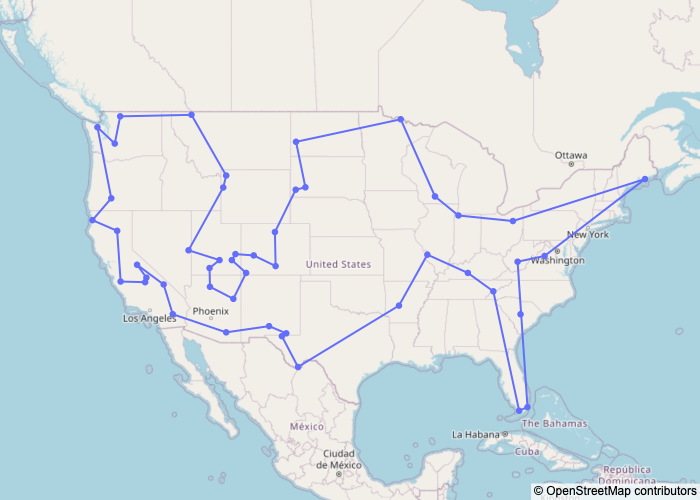

### b. ASE and MTZ Variant Results
---
The MTZ and ASE models both yielded the same solutions, as expected

In [22]:
println("Total Trip Cost: \$", round(objectiveASE, digits=2))
println("Trip length: ", round(tripMileageASE, digits=3), "mi\n")
println("Parks visited: ", Int(sum(value.(xASE))) - 1, "\n")

println("Total Trip Duration: ", round(tripDaysASE, digits=3), " days")
println("\tDriving Time: ", round(driveTimeASE, digits=3), " days")
println("\tTime Spent in Parks: ", round(parkTimeASE, digits=3), " days")

Total Trip Cost: $674.91
Trip length: 1739.0mi

Parks visited: 2

Total Trip Duration: 7.098 days
	Driving Time: 1.098 days
	Time Spent in Parks: 6.0 days


This version of our model found the optimal path to be:

UW-Madison $\rightarrow$ Great Smoky Mountains $\rightarrow$ Cuyahoga Valley $\rightarrow$ UW-Madison.

Both models represent the same way of thinking, i.e., eliminating subtours within the MCNF model, but approach them in different ways. From our analysis, we found that the route that most optimally minimizes total cost for a national park tour between 7-14 days starting from UW-Madison would be the following sequence:

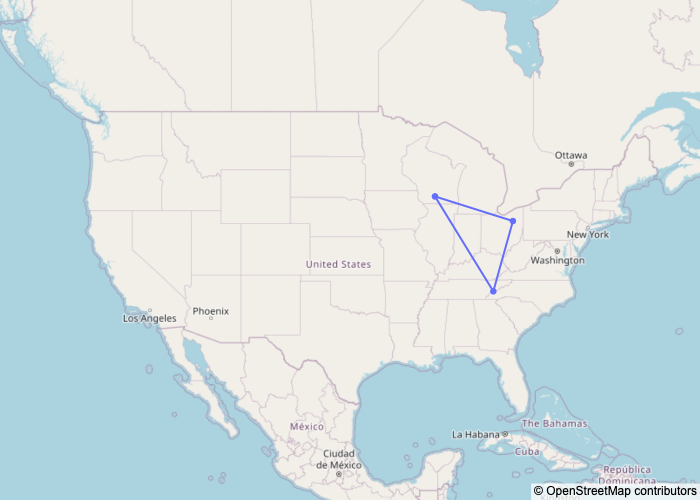

Note that the visualizations depict a "straight-line" route, however, the distance values used from one park to another are real-world values through roadways, as provided by the Google Maps API.

### c. Discussion and Limitations
---
Firstly, our models make a couple of assumptions regarding the cost of each park. On a rather high-level, this particular solution from our model assumes that the particular subset of individuals interested in National Park road trips also 
- Have their own vehicles for transport
- Are looking for a 7-14 day trip
- Are based out of Madison
- Don't have a minimum number of parks they'd like to visit, and 
- Don't have a budget (e.g. a trip under \$600)

As the length of stay is recommended from the National Parks' website, it may vary person-to-person; this, like most factors involved in planning a trip, is heavily dependent on the human factors / personal preference side of things that a more objective mathematical model may not currently account for. However, the data can be modified by the individual/(s) in question, after which re-running the same model would provide a viable solution for the set of individuals in question.

Similarly, the lodging costs are also derived from a collection of sources and don’t account for the ability to choose multiple sources of accommodation, e.g., camping, hotels, AirBNBs, staying with friends, etc. Such costs are also seasonal and change based on demand and the personalized pricing strategy of any online source used; thus, these are only an assumed average cost of lodging in the area.

Furthermore, our gas cost is an average of the cost of the state we are traveling from to the state that the park is located in; this doesn’t account for gas costs in states between the parks in question. For example, if we travel from Wisconsin to Indiana, crossing Illinois, our average gas cost excludes the gas cost in Illinois. Should we refuel in Illinois, the total gas cost would probably vary from what our model has predicted. While this likely wouldn’t change the overall objective (the total trip cost) too much, it still introduces variation and affects the robustness of our model.

Lastly, we also don’t include food cost which, while being significant on any trip, is also likely to be stable across trips and scale with the number of days traveling. Even considering the assumptions we’ve made we still believe this is a useful tool in calculating a ballpark estimate of the minimum cost of such a road trip.

## 5. Conclusion ##
---
Our model found that the most optimal route for a 7 to 14 day trip from UW-Madison visiting National Parks around the contiguous United States would be a 1739 mile, 7 day road trip visiting the Great Smoky Mountains and Cuyahoga Valley, costing __\$674.91__ including road travel costs and accommodation.

Extending this problem to travel from UW-Madison to all 48 National Parks in the contiguous United States yields a total cost of __\$22,926.88__ - a 13,873 mile road trip spanning over 139.7 days. That would surely be a fun trip after this semester!

### Future Direction
---
Our model can be furthered expanded with a few more constraints to include scenarios such as
- Spending at least a certain amount `@constraint(m, min_spending, total_cost >= YOUR_MIN_SPENDING)`
- Visiting at least `X` parks `@constraint(m, min_parks, sum(x) >= YOUR_MIN_PARKS)`
- Visting a specific number of parks `@constraint(m, parks_visited, sum(x) == YOUR_SPECIFIC_NUM_PARKS)`

where each variable with the prefix `YOUR` allows personal preference to be included in the model

In searching for national parks around the United States, our team had to exclude parks in Alaska, Hawaii, and certain island locations due to complexities in getting to said locations. In order to make our model all-encompassing, we could alter our model to include multiple methods of transport. For example, getting to Isle Royale in Michigan, requires either a private plane or a boat. If we break down the cost arc from UW-Madison to Isle Royale to include driving to Houghton County Airport, taking a shuttle to the boat boarding location, and taking the boat to Isle Royale, we can reformulate the $c_{UW-Madison, Isle Royale}$ arc to the following

$c_{UW-Madison, Isle Royale} = c_{UW-Madison, Houghton County Memorial Airport} + c_{Houghton County Memorial Airport, Shuttle} + c_{Shuttle, Boat Start} + c_{Boat Boarding, Isle Royale}$

This would then break down the cost of getting from one location to another to include multiple modes of transport. Thus, including other modes of transport as separate constituent arcs could help aid the practicality of this model.

## 6. Sources ##

Julia. (2022). https://julialang.org/. The Julia Programming Language. Retrieved August 2022, from https://julialang.org/ 

Mapbox. (2022). Mapbox GL JS. Mapbox. Retrieved August 12, 2022, from https://docs.mapbox.com/mapbox-gl-js/guides/ 

NPS. (n.d.). Entrance fees by Park (U.S. National Park Service). National Parks Service. Retrieved August 11, 2022, from https://www.nps.gov/aboutus/entrance-fee-prices.htm 

OpenJSFoundation. (2022). Version (16.16.0). NodeJS. Retrieved August 2022, from https://nodejs.org/en/. 

Plotly. (2022). Plotly. Retrieved August 12, 2022, from https://plotly.com/graphing-libraries/ 

Python. (2022). Python. Python.org. Retrieved August 12, 2022, from https://www.python.org/ 

Unknown, L. (2022, May 28). How many days to spend at each National Park. a life of adventures. Retrieved August 11, 2022, from https://alifeofadventures.com/blog/how-long-to-spend-at-each-national-park/#:~:text=Parks%20You%20Can%20Visit%20in%202%20to%204%20Days&text=4%20days%20will%20give%20you,to%20relax%20if%20you%20want

Unknown, U. (n.d.). Expedia travel: Vacation Homes, hotels, car rentals, Flights & More. Expedia.com. Retrieved August 11, 2022, from https://www.expedia.com/ 

Unknown, U. (n.d.). State gas price averages. AAA Gas Prices. Retrieved August 11, 2022, from https://gasprices.aaa.com/state-gas-price-averages/ 